# Dealing with Unbalanced Data



This dataset is a collection of transactions made by credit cards in September 2013 by European cardholders. Over a period of two days,  transactions were aggregated by the Wordline and the Machine Learning Group of  Université Libre de Bruxelles and resulted in 492 out of 284,807 transactions being a fraud. Frauds account for .172% of all transactions. 

The goal of this notebook is to explore various undersampling and oversampling methods and the pipeline in order to produce the best model. Often, we assume binary classification problems have equally distributed response variables. Most of the time, however, it is not the case. 

We want to consider the following details about the dataset:
- This dataset does not contain the original information as it is given as a result of a PCA transformation and the daata is classified.
-  Features V1, V2, ..., V28 are the principal components while Time and Amount have not been transformed. 
- Time - seconds elapsed between each transaction and the first transaction in the dataset
- Amount - transaction Amount
- Class - Response variable 
    - 0 - No fraud
    - 1 - Fraud

## Outline
1. Obtain summary statistics and brief discussion about the data. 
2. Split data into train/test sets naively (because the response variables are skewed)
3. Train several linear and non-linear models and see how well they perform.
4. Consider oversampling, undersampling, and SMOTE-based preprocessing
5. Analyze performance metrics by looking at some of the same algorithms, but uses newly processed training data

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE

C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
credit = pd.read_csv('creditcard.csv')

In [3]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
count_classes = credit["Class"].value_counts().sort_index()
print(count_classes)

0    284315
1       492
Name: Class, dtype: int64


The data is unbalanced. Therefore, we should consider other metrics besides accuracy to determine the best model. Precision, recall, and FScores would be more appropriate to use as metrics for this dataset. 

In [5]:
# Exclude time and Amount
X = credit.values[:,1:29].astype(float)
Y = credit.values[:,30]
validation_size = 0.3
seed = 7

X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,test_size=validation_size, random_state=seed)

In [6]:
print(X_train.shape)
print(type(X_train))
print(Y_train.shape)
print(type(Y_train))

(199364, 28)
<class 'numpy.ndarray'>
(199364,)
<class 'numpy.ndarray'>


In [7]:
# Test options and evaluation metric
num_folds = 15
num_instances = len(X_train)
seed = 7

In [8]:
# Instantiate scalers and models into pipeline
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))

results = []
names = []
for name, model in pipelines:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.976659 (0.017884)
ScaledLDA: 0.974522 (0.021750)
ScaledKNN: 0.914807 (0.037333)
ScaledCART: 0.870539 (0.053557)
ScaledNB: 0.956314 (0.026760)


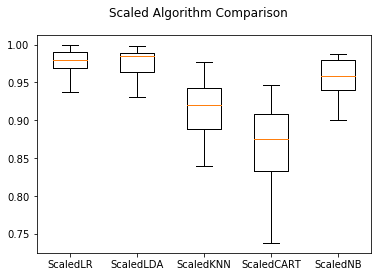

In [9]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Logistic Regression and Linear Discriminant Analysis semed to work well based on our 15-fold cross validation set. However, note that on average, the Receiver operating characteristic area under curve average is .97. Of course this is high, but remember that our data contains about 99.8% non-fraud labels. So, the AUC reflects the biasness of the data. 

In [10]:
# Fine tune Logistic Regression
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = {'C': [.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] }
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
grid = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
    

Best: 0.978317 using {'C': 0.01}
0.973330 (0.023045) with: {'C': 0.0001}
0.975491 (0.021721) with: {'C': 0.001}
0.978317 (0.019927) with: {'C': 0.01}
0.978112 (0.018627) with: {'C': 0.1}
0.976660 (0.017883) with: {'C': 1}
0.976285 (0.017805) with: {'C': 10}
0.976231 (0.017807) with: {'C': 100}
0.976226 (0.017806) with: {'C': 1000}


We also consider the best hyperparameter $C$ in Logistic Regression. Let's see how well it does on our biased trained dataset.

In [11]:
# Test LR model with C = .01
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = LogisticRegression(C=.01)
model.fit(rescaledX, Y_train)

# Test on cross validation set
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print("Logistic Regression")
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print("Classification Report: \n ", classification_report(Y_validation, predictions))
print(cohen_kappa_score(Y_validation, predictions))

Logistic Regression
0.99914562925
[[85279     9]
 [   64    91]]
Classification Report: 
               precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85288
        1.0       0.91      0.59      0.71       155

avg / total       1.00      1.00      1.00     85443

0.713317597376


Note that our recall rate is 59%. Accuracy is not a good measure in determining the fit of a model when we have a situation where our data is heavily unbalanced since frauds do not that often. This is because certain models such as CART are simple-rule based algorithms. We use the Cohen's Kappa score in order to observe that the Logistic Regression model achieved a rate of classification of 71% of the way between the expected accuracy and 100% accuracy.

Now, a model like this has very limited use. It is more important for us to classify the true negatives correctly and without balancing the data, the models will lean biased toward classifying a case as true positive. Therefore, we resort to over-sampling techniques. One popular technique is called SMOTE (Synthetic Minority Oversampling Technique). This creates versions of the minority class (in this case, the frauds) by finding similar observations using k-Nearest Neighbors and tweaking the observations. Thanks for the wisdom, Nick! (https://beckernick.github.io/oversampling-modeling/)

Now it is important to identify when we are going to perform SMOTE because if we did that to the whole dataset, what will happen is that information will bleed. If I performed SMOTE first before splitting into my train/test sets, the synthetic observations that may be classified as part of the training set may be based on some observation that is reserved for the test set. Remember, we want to keep the splits separately which means the information from any modification should be partitioned accordingly. I will think of a good analogy for this later that is probably in relation to creating a small party of people.


In [12]:
sm = SMOTE(random_state=12)
X_train_sm, Y_train_sm = sm.fit_sample(X_train, Y_train)

In [13]:
# Test options and evaluation metric
num_folds = 15
num_instances_sm = len(X_train_sm)
seed = 7
print(num_instances_sm)

398054


In [14]:
# Test LR model with C = .1
scaler = StandardScaler().fit(X_train_sm)
rescaledX = scaler.transform(X_train_sm)
model = LogisticRegression(C=.01)
model.fit(rescaledX, Y_train_sm)

# Test on cross validation set
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print("Logistic Regression")
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))
print(cohen_kappa_score(Y_validation, predictions))

Logistic Regression
0.976405322847
[[83284  2004]
 [   12   143]]
             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99     85288
        1.0       0.07      0.92      0.12       155

avg / total       1.00      0.98      0.99     85443

0.121266282733


In [15]:
# Test options and evaluation metric
num_folds = 15
num_instances_sm = len(X_train_sm)
seed = 7

In [16]:
# Fine tune Logistic Regression
scaler = StandardScaler().fit(X_train_sm)
rescaledX_sm = scaler.transform(X_train_sm)
param_grid = {'C': [.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] }
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
grid = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(rescaledX, Y_train_sm)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
    

Best: 0.979465 using {'C': 0.1}
0.952087 (0.029780) with: {'C': 0.0001}
0.957835 (0.029837) with: {'C': 0.001}
0.973486 (0.025315) with: {'C': 0.01}
0.979465 (0.020148) with: {'C': 0.1}
0.977491 (0.017658) with: {'C': 1}
0.976420 (0.017747) with: {'C': 10}
0.976244 (0.017802) with: {'C': 100}
0.976229 (0.017803) with: {'C': 1000}


# k-Nearest Neighbors
I wanted to try how k-Nearest Neigbors would act.

In [17]:
# Test kNN with 15 neighbors
model3 =  KNeighborsClassifier(n_neighbors = 15)
model3.fit(rescaledX_sm, Y_train_sm)
predictions3 = model3.predict(rescaledValidationX)

print( "k-Nearest Neighbors")
print(accuracy_score(Y_validation, predictions3))
print(confusion_matrix(Y_validation, predictions3))
print(classification_report(Y_validation, predictions3))


k-Nearest Neighbors
0.992275552122
[[84647   641]
 [   19   136]]
             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00     85288
        1.0       0.18      0.88      0.29       155

avg / total       1.00      0.99      0.99     85443



# Linear Discriminant Analysis


In [18]:
num_folds = 15
num_instances_sm = len(X_train_sm)
seed = 7


In [19]:
scaler = StandardScaler().fit(X_train_sm)
rescaledX_sm = scaler.transform(X_train_sm)
model = LinearDiscriminantAnalysis()
model.fit(rescaledX_sm, Y_train_sm)



LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [20]:
# Test on cross validation set
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print("Linear Discriminant Analysis with SMOTE")
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))
print(cohen_kappa_score(Y_validation, predictions))


Linear Discriminant Analysis with SMOTE
0.98492562293
[[84024  1264]
 [   24   131]]
             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99     85288
        1.0       0.09      0.85      0.17       155

avg / total       1.00      0.98      0.99     85443

0.166309981046
